# CMEMS NRT SSH Demo

This page will walk you through the basic usage of the Map Binning package, from installation to performing your first spatial resampling operation.

## Prerequisites

Before starting, make sure you have:
- Python 3.11 or higher
- Basic familiarity with xarray and NumPy
- [CMEMS service account (free)](https://marine.copernicus.eu)
- [Copernicus Tool](https://help.marine.copernicus.eu/en/articles/7949409-copernicus-marine-toolbox-introduction) - `copernicusmarine`

## Installation

Install the package and its dependencies using the provided environment.yml in the following repository. This ensures all required libraries including Copernicus Tool - `copernicusmarine` are installed and compatible.

```bash
# Clone and setup from environment.yml
git clone https://github.com/chiaweh2/map_binning.git
cd map_binning
conda env create -f environment.yml
conda activate map-binning
pip install -e .
```

## Setting up the CMEMS credential

Copy `.env.template` to `.env` in the root directory inside `map_binning` folder that you clone from the github and configure:

```bash
# Copernicus Marine Service credentials (if using CMEMS data)
COPERNICUSMARINE_SERVICE_USERNAME=<your_username>
COPERNICUSMARINE_SERVICE_PASSWORD=<your_password>
```

## Find the demo file

The demo jupyternotebook is located at `notebooks/cmems_example.ipynb`

## Demo Overview

This tutorial covers:
1. Loading and preparing the CMEMS data
2. Creating a binning instance
3. Generating binning indices
5. Reuse the indices for all data
6. Compare the result

## Step 1: Import Required Libraries

In [1]:
import os
from dotenv import load_dotenv
import xarray as xr
import matplotlib.pyplot as plt
import copernicusmarine
from map_binning.binning import Binning


/home/chsu/.conda/envs/map-binning/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# Try to load .env file
local_env = load_dotenv()
print(f"load_dotenv() returned: {local_env}")

# Check if running in GitHub Actions
is_github_actions = os.getenv('GITHUB_ACTIONS')
print(f"GITHUB_ACTIONS: {is_github_actions}")

# Check all environment variables (for debugging)
print("Available environment variables:")
for key in sorted(os.environ.keys()):
    if 'COPERNICUS' in key or 'CMEMS' in key:
        print(f"  {key}: {'***' if 'PASSWORD' in key else os.environ[key]}")

# Try to get credentials
username = os.getenv("COPERNICUSMARINE_SERVICE_USERNAME")
password = os.getenv("COPERNICUSMARINE_SERVICE_PASSWORD")

print(f"Username found: {username is not None}")
print(f"Password found: {password is not None}")

if username and password:
    print("✅ Credentials loaded successfully")
else:
    print("❌ Credentials not found")

load_dotenv() returned: True
GITHUB_ACTIONS: None
Available environment variables:
  COPERNICUSMARINE_SERVICE_PASSWORD: ***
  COPERNICUSMARINE_SERVICE_USERNAME: chsu8
Username found: True
Password found: True
✅ Credentials loaded successfully


:::{admonition} Techical info 
:class: info 
The `load_dotenv()` function loads your CMEMS credentials so you do not need to type your username and password directly in the script, which could pose a security risk. The `.env` file is also included in the `.gitignore` file to prevent it from being uploaded or pushed to the GitHub repository.
:::

## Step 2: Prepare Your Data

### Lazy Loading CMEMS Data

In [10]:
import time
# time the lazy loading process
start = time.time()

# real command to lazy load the data
ds_0p25 = copernicusmarine.open_dataset(dataset_id="cmems_obs-sl_glo_phy-ssh_nrt_allsat-l4-duacs-0.25deg_P1D")

# calculate elapsed time
elapsed = time.time() - start
print(f"Lazy loading ds_0p25 took {elapsed:.2f} seconds")

INFO - 2025-09-10T16:41:44Z - Selected dataset version: "202311"
INFO - 2025-09-10T16:41:44Z - Selected dataset part: "default"


Lazy loading ds_0p25 took 5.16 seconds


In [4]:
ds_0p25

<xarray.Dataset> Size: 65GB
Dimensions:    (time: 784, latitude: 720, longitude: 1440, nv: 2)
Coordinates:
    lat_bnds   (latitude, nv) float32 6kB dask.array<chunksize=(720, 2), meta=np.ndarray>
  * latitude   (latitude) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
    lon_bnds   (longitude, nv) float32 12kB dask.array<chunksize=(1024, 2), meta=np.ndarray>
  * longitude  (longitude) float32 6kB -179.9 -179.6 -179.4 ... 179.6 179.9
  * nv         (nv) int32 8B 0 1
  * time       (time) datetime64[ns] 6kB 2022-10-04 2022-10-05 ... 2024-11-25
Data variables:
    adt        (time, latitude, longitude) float64 7GB dask.array<chunksize=(50, 720, 1024), meta=np.ndarray>
    err_sla    (time, latitude, longitude) float64 7GB dask.array<chunksize=(50, 720, 1024), meta=np.ndarray>
    err_ugosa  (time, latitude, longitude) float64 7GB dask.array<chunksize=(50, 720, 1024), meta=np.ndarray>
    err_vgosa  (time, latitude, longitude) float64 7GB dask.array<chunksize=(50, 720, 1024), meta=np.ndarray>
    flag_ice   (time, latitude, longitude) float64 7GB dask.array<chunksize=(50, 720, 1024), meta=np.ndarray>
    sla        (time, latitude, longitude) float64 7GB dask.array<chunksize=(50, 720, 1024), meta=np.ndarray>
    ugos       (time, latitude, longitude) float64 7GB dask.array<chunksize=(50, 720, 1024), meta=np.ndarray>
    ugosa      (time, latitude, longitude) float64 7GB dask.array<chunksize=(50, 720, 1024), meta=np.ndarray>
    vgos       (time, latitude, longitude) float64 7GB dask.array<chunksize=(50, 720, 1024), meta=np.ndarray>
    vgosa      (time, latitude, longitude) float64 7GB dask.array<chunksize=(50, 720, 1024), meta=np.ndarray>
Attributes:
    institution:  CLS, CNES
    references:   http://marine.copernicus.eu
    title:        NRT merged all satellites Global Ocean Gridded SSALTO/DUACS...
    Conventions:  CF-1.6
    contact:      servicedesk.cmems@mercator-ocean.eu
    source:       Altimetry measurements
    comment:      Sea Surface Height measured by Altimetry and derived variables
    history:      2023-11-24 00:53:07Z: Creation

:::{admonition} Lazy loading CMEMS data
:class: info 
Thanks to the integration of the CMEMS tool with Xarray, you can leverage powerful lazy loading—accessing data on-the-fly without downloading the entire dataset first. This allows you to quickly inspect metadata and variable structure within seconds, even for very large datasets like `ds_0p25` (65GB) shown above.
:::

Let's do the same for the higher resolution data that started from July 2024.

In [5]:
ds_0p125 = copernicusmarine.open_dataset(dataset_id="cmems_obs-sl_glo_phy-ssh_nrt_allsat-l4-duacs-0.125deg_P1D")

INFO - 2025-09-10T16:34:36Z - Selected dataset version: "202506"
INFO - 2025-09-10T16:34:36Z - Selected dataset part: "default"


In [6]:
ds_0p125

<xarray.Dataset> Size: 145GB
Dimensions:    (time: 437, latitude: 1440, longitude: 2880, nv: 2)
Coordinates:
    lat_bnds   (latitude, nv) float32 12kB dask.array<chunksize=(1024, 2), meta=np.ndarray>
  * latitude   (latitude) float32 6kB -89.94 -89.81 -89.69 ... 89.69 89.81 89.94
    lon_bnds   (longitude, nv) float32 23kB dask.array<chunksize=(1024, 2), meta=np.ndarray>
  * longitude  (longitude) float32 12kB -179.9 -179.8 -179.7 ... 179.8 179.9
  * nv         (nv) int32 8B 0 1
  * time       (time) datetime64[ns] 3kB 2024-07-01 2024-07-02 ... 2025-09-10
Data variables:
    adt        (time, latitude, longitude) float64 14GB dask.array<chunksize=(50, 1024, 1024), meta=np.ndarray>
    err_sla    (time, latitude, longitude) float64 14GB dask.array<chunksize=(50, 1024, 1024), meta=np.ndarray>
    err_ugosa  (time, latitude, longitude) float64 14GB dask.array<chunksize=(50, 1024, 1024), meta=np.ndarray>
    err_vgosa  (time, latitude, longitude) float64 14GB dask.array<chunksize=(50, 1024, 1024), meta=np.ndarray>
    flag_ice   (time, latitude, longitude) float64 14GB dask.array<chunksize=(50, 1024, 1024), meta=np.ndarray>
    sla        (time, latitude, longitude) float64 14GB dask.array<chunksize=(50, 1024, 1024), meta=np.ndarray>
    ugos       (time, latitude, longitude) float64 14GB dask.array<chunksize=(50, 1024, 1024), meta=np.ndarray>
    ugosa      (time, latitude, longitude) float64 14GB dask.array<chunksize=(50, 1024, 1024), meta=np.ndarray>
    vgos       (time, latitude, longitude) float64 14GB dask.array<chunksize=(50, 1024, 1024), meta=np.ndarray>
    vgosa      (time, latitude, longitude) float64 14GB dask.array<chunksize=(50, 1024, 1024), meta=np.ndarray>
Attributes:
    institution:  CLS, CNES
    references:   http://marine.copernicus.eu
    title:        NRT merged all satellites Global Ocean Gridded SSALTO/DUACS...
    Conventions:  CF-1.6
    contact:      servicedesk.cmems@mercator-ocean.eu
    source:       Altimetry measurements
    comment:      Sea Surface Height measured by Altimetry and derived variables
    history:      2025-04-17 20:03:53Z: Creation

To demonstrate the binning results, we select the overlapping period between the two datasets and use the `sla` (Sea Level Anomaly) variable. This allows for a direct comparison between the binned high-resolution data and the original low-resolution data later on.

In [11]:
import time

start = time.time()

da_sla_0p25 = ds_0p25['sla'].sel(time='2024-07-01').load()
da_sla_0p125 = ds_0p125['sla'].sel(time='2024-07-01').load()

elapsed = time.time() - start
print(f"Downloading and loading da_sla_0p25 and da_sla_0p125 took {elapsed:.2f} seconds")

Let's quickly plot the two datasets to get a first glance at their differences.

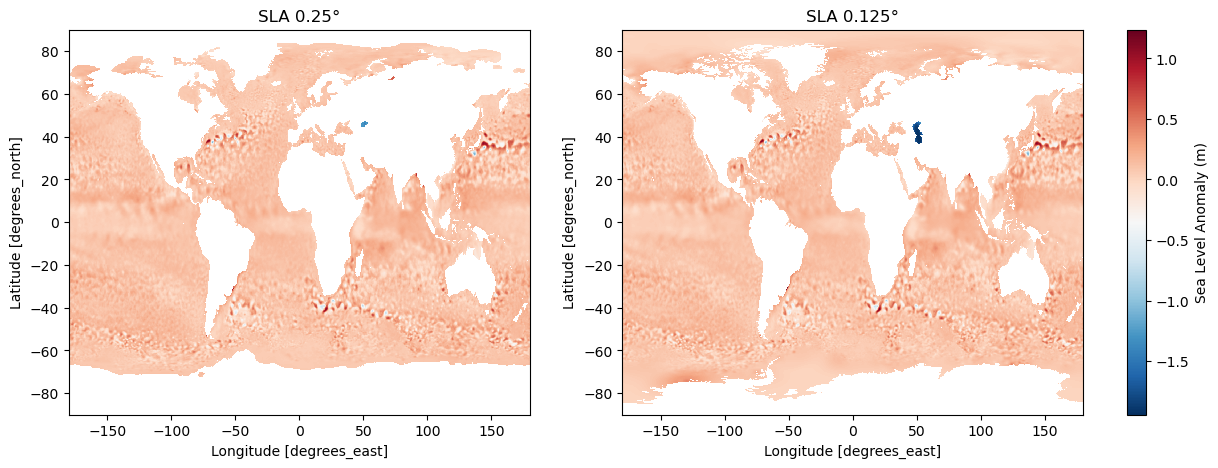

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

vmin = min(da_sla_0p25.min().item(), da_sla_0p125.min().item())
vmax = max(da_sla_0p25.max().item(), da_sla_0p125.max().item())

im0 = da_sla_0p25.plot(ax=axes[0], cmap='RdBu_r', vmin=vmin, vmax=vmax, add_colorbar=False)
axes[0].set_title('SLA 0.25°')

im1 = da_sla_0p125.plot(ax=axes[1], cmap='RdBu_r', vmin=vmin, vmax=vmax, add_colorbar=False)
axes[1].set_title('SLA 0.125°')

fig.colorbar(im1, ax=axes, orientation='vertical', fraction=0.025, pad=0.04, label='Sea Level Anomaly (m)')

plt.show()

**Figure:** (Left) SLA at 0.25° resolution (`ds_0p25`). (Right) SLA at 0.125° resolution (`ds_0p125`).  
Both plots use the same color scale for direct comparison. Notice the finer spatial details captured in the higher-resolution dataset.


## Step 3: Create Binning Instance and Perform Binning

In [17]:
# prepare the datasets for binning
ds_high = da_sla_0p125.to_dataset(name='sla')
ds_low = da_sla_0p25.to_dataset(name='sla')

# Initialize the binning object and perform mean binning
binning = Binning(
    ds_high=ds_high,
    ds_low=ds_low,
    var_name='sla',
    xdim_name='longitude',
    ydim_name='latitude',
    search_radius=0.25/2.0,  # half of the low-res grid size in degrees
)
binned_data = binning.mean_binning()
print(binned_data)

print("Binning completed successfully!")

/home/chsu/map-binning-project/map_binning/binning.py:209: RuntimeWarning: Mean of empty slice
  output[i, j] = np.nanmean(values)


<xarray.DataArray 'sla' (latitude: 720, longitude: 1440)> Size: 8MB
array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [-0.00235 , -0.00235 , -0.00235 , ..., -0.00235 , -0.00235 ,
        -0.00235 ],
       [-0.0021  , -0.00205 , -0.00205 , ..., -0.0021  , -0.0021  ,
        -0.0021  ],
       [-0.001825, -0.0018  , -0.0018  , ..., -0.00185 , -0.00185 ,
        -0.00185 ]], shape=(720, 1440))
Coordinates:
  * latitude   (latitude) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 6kB -179.9 -179.6 -179.4 ... 179.6 179.9
Binning completed successfully!


Let's plot the binned result alongside the original low-resolution data to visually compare the differences.

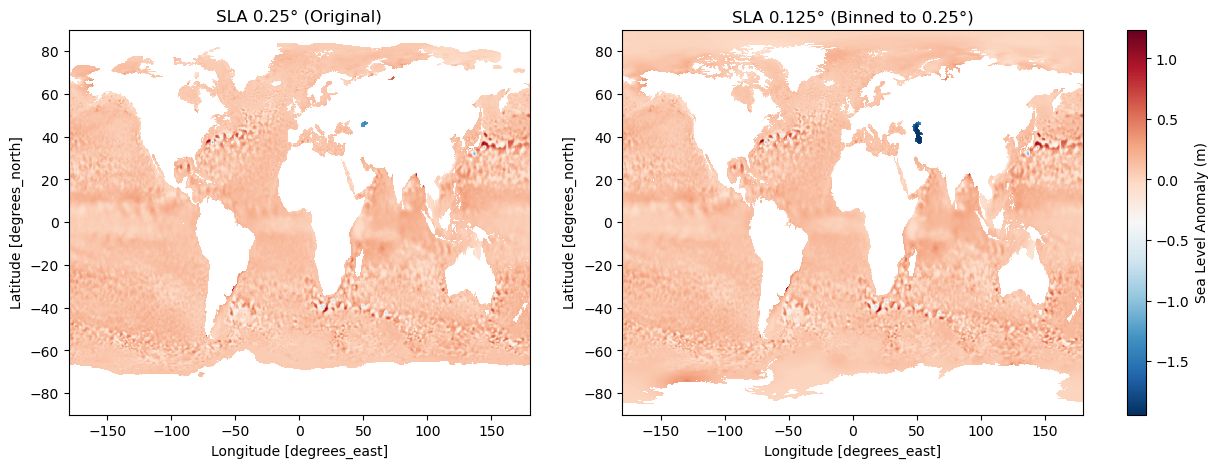

In [18]:
da_sla_0p125_binned = binned_data

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

im0 = da_sla_0p25.plot(ax=axes[0], cmap='RdBu_r', vmin=vmin, vmax=vmax, add_colorbar=False)
axes[0].set_title('SLA 0.25° (Original)')

im1 = da_sla_0p125_binned.plot(ax=axes[1], cmap='RdBu_r', vmin=vmin, vmax=vmax, add_colorbar=False)
axes[1].set_title('SLA 0.125° (Binned to 0.25°)')

fig.colorbar(im1, ax=axes, orientation='vertical', fraction=0.025, pad=0.04, label='Sea Level Anomaly (m)')

plt.show()

**Figure:** (Left) Original SLA at 0.25° resolution. (Right) High-resolution 0.125° SLA binned to the 0.25° grid. Both panels use the same color scale for direct visual comparison.

We can zoom in to the US east coast where there is large eddies from the Gulf stream to see the differences in more detail.

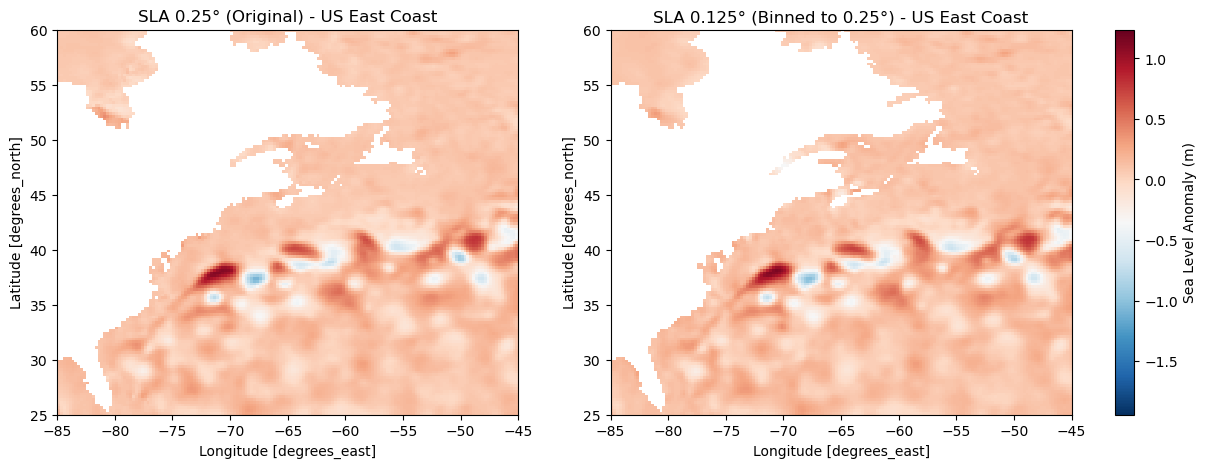

In [20]:
# Define the bounding box for the US east coast (approximate)
lat_min, lat_max = 25, 60    # degrees North
lon_min, lon_max = -85, -45  # degrees East

# Select the region for both datasets
da_sla_0p25_eastcoast = da_sla_0p25.sel(
    latitude=slice(lat_min, lat_max),
    longitude=slice(lon_min, lon_max)
)
da_sla_0p125_binned_eastcoast = da_sla_0p125_binned.sel(
    latitude=slice(lat_min, lat_max),
    longitude=slice(lon_min, lon_max)
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

im0 = da_sla_0p25_eastcoast.plot(ax=axes[0], cmap='RdBu_r', vmin=vmin, vmax=vmax, add_colorbar=False)
axes[0].set_title('SLA 0.25° (Original) - US East Coast')

im1 = da_sla_0p125_binned_eastcoast.plot(ax=axes[1], cmap='RdBu_r', vmin=vmin, vmax=vmax, add_colorbar=False)
axes[1].set_title('SLA 0.125° (Binned to 0.25°) - US East Coast')

fig.colorbar(im1, ax=axes, orientation='vertical', fraction=0.025, pad=0.04, label='Sea Level Anomaly (m)')

plt.show()

**Figure:** Comparison of Sea Level Anomaly (SLA) along the US East Coast.  
(Left) Original 0.25° SLA from the low-resolution dataset.  
(Right) High-resolution 0.125° SLA binned to the 0.25° grid.  
Both panels use the same color scale, highlighting the differences and additional spatial detail captured by the higher-resolution data after binning.

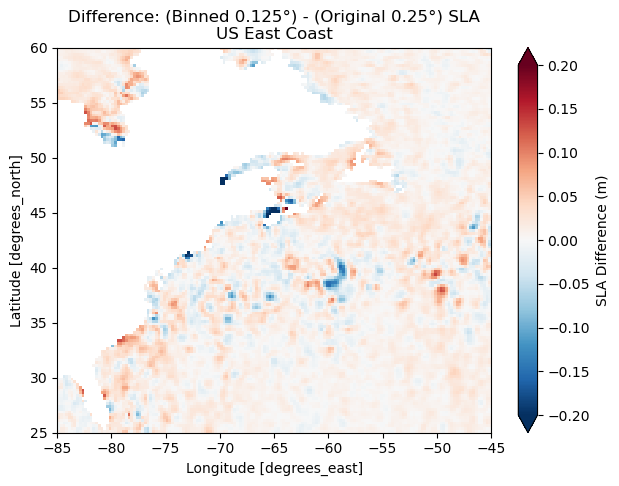

In [21]:
# Compute the difference between the binned high-res and original low-res datasets for the US east coast
diff_eastcoast = da_sla_0p125_binned_eastcoast - da_sla_0p25_eastcoast

plt.figure(figsize=(7, 5))
im = diff_eastcoast.plot(cmap='RdBu_r', vmin=-0.2, vmax=0.2, cbar_kwargs={'label': 'SLA Difference (m)'})
plt.title('Difference: (Binned 0.125°) - (Original 0.25°) SLA\nUS East Coast')
plt.show()


## Step 4: Save the binning index for multi-timeslice processes

### Using Precomputed Binning Index for Better Performance

For multiple operations on the same grids, you can use precomputed indices:

In [ ]:
# Create a binning index for reuse
binning = binning = Binning(
    ds_high=ds_high,
    ds_low=ds_low,
    var_name='sla',
    xdim_name='longitude',
    ydim_name='latitude',
    search_radius=0.25/2.0,  # half of the low-res grid size in degrees
)

# create the index and save it to a variable
index = binning.create_binning_index()


/home/chsu/map-binning-project/map_binning/binning.py:209: RuntimeWarning: Mean of empty slice
  output[i, j] = np.nanmean(values)


Binning with precomputed index completed!


In [23]:
# let's load another time slice to demonstrate reusing the index
da_sla_0p125_aug = ds_0p125['sla'].sel(time='2024-08-01').load()
ds_high_aug = da_sla_0p125_aug.to_dataset(name='sla')

# Now use the precomputed index for faster binning
binning = Binning(
    ds_high=ds_high_aug,
    ds_low=ds_low,
    var_name='sla',
    xdim_name='longitude',
    ydim_name='latitude',
    search_radius=None,  # the radius is not needed when using precomputed index, the set number will be ignored
)

da_sla_0p125_aug_binned = binning.mean_binning(precomputed_binning_index=index)
print("Binning with precomputed index completed!")

/home/chsu/map-binning-project/map_binning/binning.py:209: RuntimeWarning: Mean of empty slice
  output[i, j] = np.nanmean(values)


Binning with precomputed index completed!


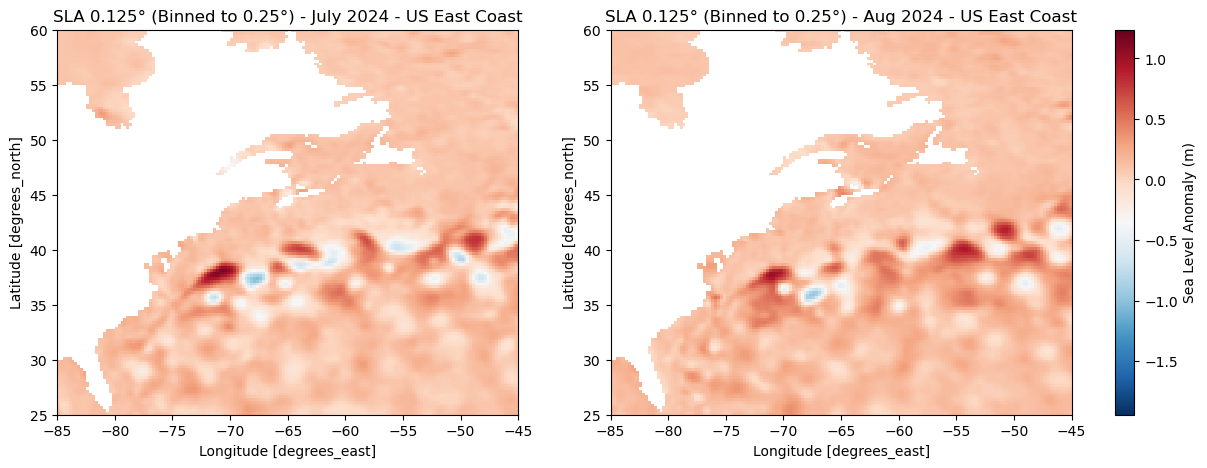

In [24]:
# Select the east coast region for both July and August binned results
da_sla_0p125_binned_eastcoast_july = da_sla_0p125_binned.sel(
    latitude=slice(lat_min, lat_max),
    longitude=slice(lon_min, lon_max)
)
da_sla_0p125_binned_eastcoast_aug = da_sla_0p125_aug_binned.sel(
    latitude=slice(lat_min, lat_max),
    longitude=slice(lon_min, lon_max)
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

im0 = da_sla_0p125_binned_eastcoast_july.plot(
    ax=axes[0], cmap='RdBu_r', vmin=vmin, vmax=vmax, add_colorbar=False
)
axes[0].set_title('SLA 0.125° (Binned to 0.25°) - July 2024 - US East Coast')

im1 = da_sla_0p125_binned_eastcoast_aug.plot(
    ax=axes[1], cmap='RdBu_r', vmin=vmin, vmax=vmax, add_colorbar=False
)
axes[1].set_title('SLA 0.125° (Binned to 0.25°) - Aug 2024 - US East Coast')

fig.colorbar(im1, ax=axes, orientation='vertical', fraction=0.025, pad=0.04, label='Sea Level Anomaly (m)')

plt.show()

**Figure:** Comparison of binned SLA for the US East Coast in July and August 2024.  
(Left) SLA 0.125° binned to 0.25° grid for July 2024.  
(Right) SLA 0.125° binned to 0.25° grid for August 2024.  
Both panels use the same color scale, highlighting temporal changes in sea level anomaly patterns.